# Air Quality Prediction

[World's Air Pollution: Real-Time Air Quality Index](https://waqi.info/)

https://aqicn.org/json-api/doc/

## Prepare environment

In [1]:
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.signal import periodogram

import torch
import torch.nn as nn
import torch.optim as optim

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Make random numbers stable for reproduction
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Add sources to the path
import sys
from pathlib import Path
PROJECT_ROOT = str(Path().resolve().parent)
sys.path.append(PROJECT_ROOT)

from src.data import aqi, meteo
from src.data.calendar import add_calendar_features
from src.data.features import FeatureScaler, split_to_windows, flatten_windows, _flatten_windows # TODO: don't use internal methods
from src.model.training import split_data
from src.model.evaluation import evaluate_iaqi_predictions, create_metrics_dataframe, get_day_n_metrics
from src.model.inference import recursive_forecasting
from src.model import xgboost
from src.hopsworks.client import HopsworksClient
from src.common import LOGGER_NAME, IAQI_FEATURES

import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(name)s - %(message)s"
)

LOGGER = logging.getLogger(LOGGER_NAME)
LOGGER.setLevel(logging.DEBUG)

## Configuration

In [2]:
# How many (lagged) days to use as input during training
historical_window_size = 3
# How many days to teach the model to predict 
prediction_window_size = 3
# TODO: use recursive_forecasting boolean instead
# How many predictions to do as part of recursive forecasting
num_of_predictions = 1

## Prepare data

### Load data

In [3]:
aqi_df = aqi.load_data(PROJECT_ROOT)

2025-08-07 09:08:47,026 INFO: Initializing external client
2025-08-07 09:08:47,027 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-08-07 09:08:48,586 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1239207
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 


In [4]:
# Make sure column names are stripped
aqi_df.columns

Index(['pm25', 'pm10', 'no2', 'so2', 'co'], dtype='object')

In [5]:
aqi_df.head()

,pm25,pm10,no2,so2,co
2021-12-27,NaN,37.0,25.0,2.0,12.0
2021-12-28,105.0,36.0,21.0,3.0,9.0
2021-12-29,104.0,26.0,17.0,1.0,10.0
2021-12-30,73.0,17.0,8.0,1.0,9.0
2021-12-31,56.0,6.0,5.0,1.0,12.0


In [6]:
aqi_df.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,pm25,pm10,no2,so2,co
count,1317.000000,1318.000000,1309.000000,1223.000000,1311.000000
mean,44.710014,15.041622,5.565002,3.138894,3.999019
std,18.205347,7.747241,3.747337,1.687464,1.553421
min,10.000000,2.000000,1.000000,1.000000,1.000000
25%,31.000000,10.000000,3.000000,2.000000,3.000000
50%,43.000000,14.000000,5.000000,3.000000,4.000000
75%,55.000000,19.000000,7.000000,4.000000,5.000000
90%,68.000000,25.000000,11.000000,5.000000,6.000000
95%,76.000000,29.000000,13.000000,6.000000,7.000000
max,117.000000,90.000000,27.000000,15.000000,12.000000


### Handle missing dates

In [7]:
aqi_df = aqi.clean_missing_dates(aqi_df)

2025-08-07 09:08:53,018 DEBUG: Missing dates: DatetimeIndex(['2024-12-30'], dtype='datetime64[ns]', freq='D')
2025-08-07 09:08:53,029 DEBUG: Missing dates after cleanup: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


### Handle N/A values

In [8]:
aqi_df = aqi.clean_missing_values(aqi_df)

2025-08-07 09:08:53,054 DEBUG: Missing values:
pm25     2
pm10     2
no2     11
so2     97
co       9
dtype: int64
2025-08-07 09:08:53,060 DEBUG: Missing values after cleaning:
pm25    0
pm10    0
no2     0
so2     0
co      0
dtype: int64


## Feature engineering

### Calendar Features

In [9]:
aqi_df = add_calendar_features(aqi_df)
aqi_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,week_of_year,is_leap_year,is_working_day,is_feb29
2021-12-27,43.0,37.0,25.0,2.0,12.0,2021,12,27,0,361,52,0,1,0
2021-12-28,105.0,36.0,21.0,3.0,9.0,2021,12,28,1,362,52,0,1,0
2021-12-29,104.0,26.0,17.0,1.0,10.0,2021,12,29,2,363,52,0,1,0
2021-12-30,73.0,17.0,8.0,1.0,9.0,2021,12,30,3,364,52,0,1,0
2021-12-31,56.0,6.0,5.0,1.0,12.0,2021,12,31,4,365,52,0,1,0


### Cyclical features

TODO: 
For cyclical features (month, day_of_week, hour, day_of_year), it's often better to transform them
into sine and cosine components to preserve the cyclical nature and avoid arbitrary ordinal relationships.

### Meteorological data

[Meteorological Parameters](https://dev.meteostat.net/formats.html#meteorological-parameters)

In [10]:
weather_df = meteo.fetch_daily_data(aqi_df)
weather_df.head()

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
time,,,,,,,,
2021-12-27,-13.1,-17.2,-8.0,<NA>,<NA>,2.7,13.0,1009.1
2021-12-28,-9.3,-13.8,-2.0,<NA>,<NA>,4.0,13.0,1006.6
2021-12-29,-4.1,-8.1,-0.9,<NA>,<NA>,4.8,14.8,1005.6
2021-12-30,-3.6,-9.6,1.8,<NA>,<NA>,4.7,13.0,1015.0
2021-12-31,3.9,-0.2,8.2,<NA>,<NA>,15.2,33.3,1017.1


In [11]:
weather_df.describe()

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
count,1320.0,1320.0,1320.0,1185.0,4.0,1320.0,1309.0,1320.0
mean,7.990758,2.701515,13.268939,2.151899,2.0,12.464394,26.559053,1016.204318
std,8.003741,7.387561,9.13585,4.486769,1.414214,6.617045,9.249922,7.956208
min,-13.1,-20.2,-8.0,0.0,1.0,2.6,11.1,987.5
25%,1.275,-2.9,6.075,0.0,1.0,7.8,20.4,1011.6
50%,7.95,3.0,13.3,0.1,1.5,10.4,24.1,1016.65
75%,14.9,8.7,20.9,2.1,2.5,15.3,31.5,1021.2
max,24.5,18.4,34.0,42.7,4.0,47.8,57.4,1039.8


In [12]:
weather_df = meteo.clean_missing_values(weather_df)

2025-08-07 09:08:57,570 DEBUG: Missing values:
tavg       0
tmin       0
tmax       0
prcp     135
snow    1316
wspd       0
wpgt      11
pres       0
dtype: int64
2025-08-07 09:08:57,582 DEBUG: Missing values after cleaning:
tavg    0
tmin    0
tmax    0
prcp    0
snow    0
wspd    0
wpgt    0
pres    0
dtype: int64


In [13]:
merged_df = pd.merge_asof(aqi_df, weather_df, left_index=True, right_index=True)

In [14]:
merged_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
2021-12-27,43.0,37.0,25.0,2.0,12.0,2021,12,27,0,361,...,1,0,-13.1,-17.2,-8.0,0.0,0.0,2.7,13.0,1009.1
2021-12-28,105.0,36.0,21.0,3.0,9.0,2021,12,28,1,362,...,1,0,-9.3,-13.8,-2.0,0.0,0.0,4.0,13.0,1006.6
2021-12-29,104.0,26.0,17.0,1.0,10.0,2021,12,29,2,363,...,1,0,-4.1,-8.1,-0.9,0.0,0.0,4.8,14.8,1005.6
2021-12-30,73.0,17.0,8.0,1.0,9.0,2021,12,30,3,364,...,1,0,-3.6,-9.6,1.8,0.0,0.0,4.7,13.0,1015.0
2021-12-31,56.0,6.0,5.0,1.0,12.0,2021,12,31,4,365,...,1,0,3.9,-0.2,8.2,0.0,0.0,15.2,33.3,1017.1


In [15]:
all_columns = merged_df.columns

### Target columns

In [16]:
target_columns = all_columns

### Convert all features to float

Converting all features to floats is a fundamental preprocessing step for neural networks. It ensures compatibility with the underlying mathematical operations, facilitates normalization, and aligns with the requirements of deep learning frameworks.

In [17]:
merged_df = merged_df.astype(float)

In [18]:
merged_df.dtypes

pm25              float64
pm10              float64
no2               float64
so2               float64
co                float64
year              float64
month             float64
day_of_month      float64
day_of_week       float64
day_of_year       float64
week_of_year      float64
is_leap_year      float64
is_working_day    float64
is_feb29          float64
tavg              float64
tmin              float64
tmax              float64
prcp              float64
snow              float64
wspd              float64
wpgt              float64
pres              float64
dtype: object

## Explore trends

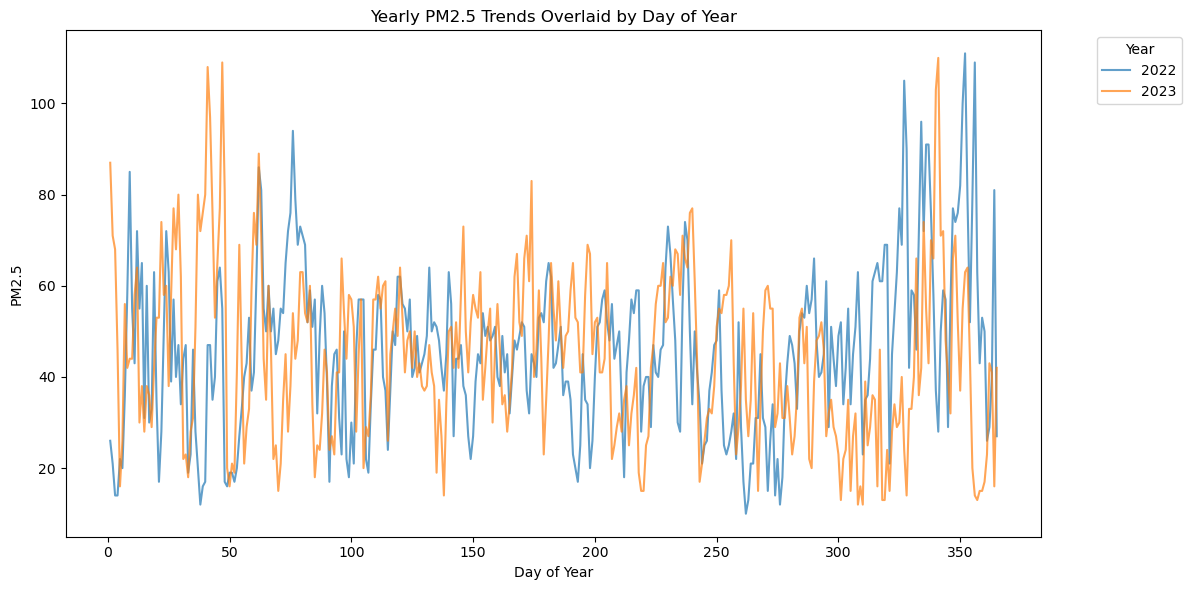

In [19]:
plt.figure(figsize=(12, 6))
for year, group in aqi_df.groupby("year"):
    if (year in [2022, 2023]):
        plt.plot(group["day_of_year"], group["pm25"], label=str(year), alpha=0.7)

plt.xlabel("Day of Year")
plt.ylabel("PM2.5")
plt.title("Yearly PM2.5 Trends Overlaid by Day of Year")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

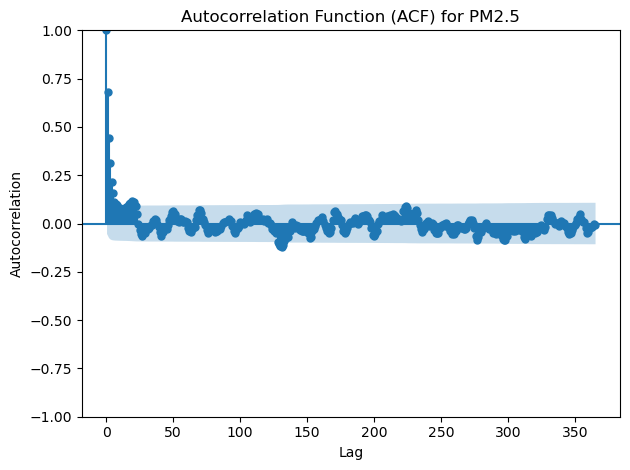

In [20]:
plt.figure(figsize=(10, 5))
plot_acf(aqi_df["pm25"], lags=365)
plt.title("Autocorrelation Function (ACF) for PM2.5")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

2025-08-07 09:08:58,200 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-07 09:08:58,209 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


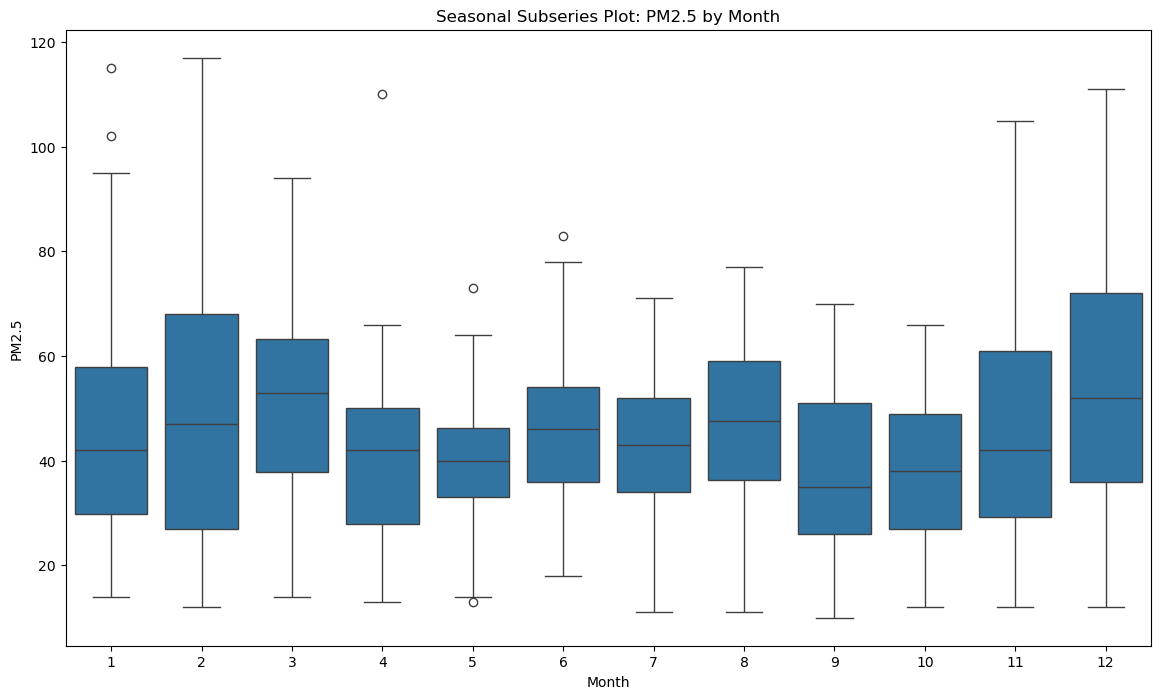

In [21]:
plt.figure(figsize=(14, 8))
sns.boxplot(x="month", y="pm25", data=aqi_df)
plt.title("Seasonal Subseries Plot: PM2.5 by Month")
plt.xlabel("Month")
plt.ylabel("PM2.5")
plt.show()

<Figure size 1400x1000 with 0 Axes>

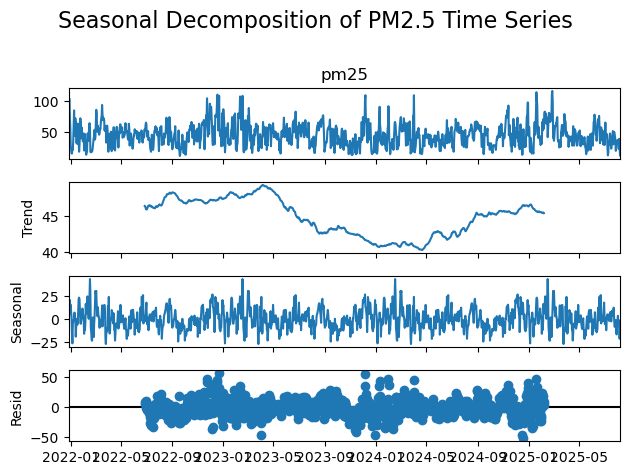

In [22]:
# Ensure pm25 is float and has no missing values for decomposition
pm25_series = aqi_df["pm25"].astype(float).interpolate()

result = seasonal_decompose(pm25_series, model='additive', period=365)

plt.figure(figsize=(14, 10))
result.plot()
plt.suptitle("Seasonal Decomposition of PM2.5 Time Series", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

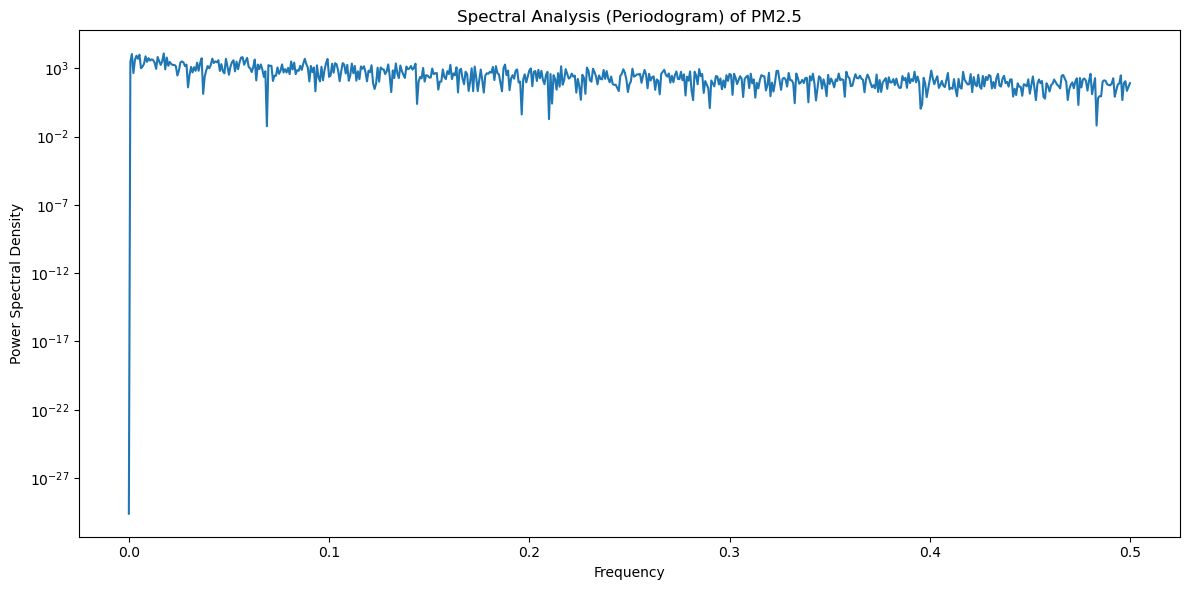

In [23]:
# Fill missing values in pm25 for spectral analysis
pm25_filled = aqi_df["pm25"].astype(float).values

# Compute the periodogram
freqs, power = periodogram(pm25_filled)

plt.figure(figsize=(12, 6))
plt.semilogy(freqs, power)
plt.title("Spectral Analysis (Periodogram) of PM2.5")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.tight_layout()
plt.show()

## Split Data into Training, Validation, and Test Sets

In [24]:
train_df, val_df, test_df = split_data(merged_df)

## Feature Scaling

Not strictly required for tree-based models (Random Forest, Gradient Boosting like XGBoost/LightGBM) as they are scale-invariant, but also don't hurt performance of these models.
However, it is a must for Neural Networks.

In [25]:
feature_scaler = FeatureScaler()
feature_scaler.fit(train_df)

train_df = feature_scaler.transform(train_df)
val_df = feature_scaler.transform(val_df)
test_df = feature_scaler.transform(test_df)

In [26]:
train_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
2021-12-27,-0.089066,2.835277,5.228242,-0.719909,5.800846,-2.388152,1.687151,1.282254,-1.499469,1.789680,...,1.0,0.0,-2.696569,-2.768650,-2.375509,-0.475501,-0.041321,-1.450669,-1.452521,-0.853784
2021-12-28,3.369620,2.705777,4.155782,-0.144418,3.714438,-2.388152,1.687151,1.395573,-0.999172,1.799415,...,1.0,0.0,-2.218416,-2.304998,-1.715680,-0.475501,-0.041321,-1.257949,-1.452521,-1.164649
2021-12-29,3.313835,1.410771,3.083322,-1.295401,4.409908,-2.388152,1.687151,1.508893,-0.498875,1.809150,...,1.0,0.0,-1.564102,-1.527699,-1.594712,-0.475501,-0.041321,-1.139351,-1.258742,-1.288995
2021-12-30,1.584492,0.245266,0.670287,-1.295401,3.714438,-2.388152,1.687151,1.622213,0.001421,1.818885,...,1.0,0.0,-1.501187,-1.732251,-1.297789,-0.475501,-0.041321,-1.154176,-1.452521,-0.120142
2021-12-31,0.636142,-1.179240,-0.134057,-1.295401,5.800846,-2.388152,1.687151,1.735533,0.501718,1.828620,...,1.0,0.0,-0.557464,-0.450390,-0.593971,-0.475501,-0.041321,0.402414,0.732882,0.140984


## Prepare prediction windows

In [27]:
(
    X_window_train,
    X_window_val,
    X_window_test,
    y_window_train,
    y_window_val,
    y_window_test,
) = split_to_windows(
    train_df, val_df, test_df, historical_window_size, prediction_window_size, target_columns=target_columns
)

In [28]:
X_window_train[-1]

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
2024-11-11,2.309700,1.669772,1.474632,-0.719909,1.628030,1.288071,1.389717,-0.530865,-1.499469,1.351594,...,1.0,0.0,-1.186612,-1.404968,-0.505994,-0.475501,-0.041321,-0.976280,-1.258742,1.297403
2024-11-12,1.584492,2.576276,0.938402,-0.719909,0.932561,1.288071,1.389717,-0.417545,-0.999172,1.361329,...,1.0,0.0,-1.199195,-1.282236,-0.945880,-0.475501,-0.041321,-0.976280,-1.452521,1.210361
2024-11-13,2.700197,-0.143235,0.134057,-0.719909,0.237092,1.288071,1.389717,-0.304225,-0.498875,1.371064,...,1.0,0.0,-1.249527,-0.954952,-1.539726,-0.475501,-0.041321,-1.154176,-1.258742,1.061145


In [29]:
y_window_train[-1]

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
2024-11-14,-0.033281,0.245266,1.206517,-0.719909,0.932561,1.288071,1.389717,-0.190905,0.001421,1.380800,...,1.0,0.0,-1.174030,-0.736763,-1.429755,-0.475501,-0.041321,0.031797,-0.462092,0.700542
2024-11-15,0.245645,0.633768,0.670287,-0.719909,0.237092,1.288071,1.389717,-0.077586,0.501718,1.390535,...,1.0,0.0,-0.960119,-1.132231,-0.890894,-0.475501,-0.041321,-0.323995,-0.257547,0.563761
2024-11-16,0.915068,-0.272736,0.134057,-0.719909,0.237092,1.288071,1.389717,0.035734,1.002015,1.400270,...,0.0,0.0,-1.224361,-1.077684,-1.231806,-0.475501,-0.041321,-0.887332,-0.462092,0.526457


## Training and Evaluation

In [30]:
# Flatten for regressors
X_flat_train, X_flat_val, X_flat_test, y_flat_train, y_flat_val, y_flat_test = flatten_windows(X_window_train, X_window_val, X_window_test, y_window_train, y_window_val, y_window_test)

In [31]:
X_flat_train[-1]

array([ 2.30969991,  1.66977216,  1.47463233, -0.71990918,  1.62803041,
        1.28807057,  1.38971669, -0.53086521, -1.49946879,  1.35159387,
        1.38155922,  1.        ,  1.        ,  0.        , -1.18661249,
       -1.40496758, -0.50599389, -0.47550134, -0.04132137, -0.97628015,
       -1.25874169,  1.29740276,  1.58449154,  2.57627597,  0.93840239,
       -0.71990918,  0.93256111,  1.28807057,  1.38971669, -0.41754529,
       -0.9991721 ,  1.3613291 ,  1.38155922,  1.        ,  1.        ,
        0.        , -1.19919547, -1.28223614, -0.94587992, -0.47550134,
       -0.04132137, -0.97628015, -1.4525213 ,  1.21036052,  2.70019673,
       -0.14323545,  0.13405748, -0.71990918,  0.23709181,  1.28807057,
        1.38971669, -0.30422536, -0.4988754 ,  1.37106434,  1.38155922,
        1.        ,  1.        ,  0.        , -1.24952736, -0.95495232,
       -1.53972605, -0.47550134, -0.04132137, -1.15417615, -1.25874169,
        1.06114525])

In [32]:
y_flat_train[-1]

array([-3.32809786e-02,  2.45266181e-01,  1.20651736e+00, -7.19909181e-01,
        9.32561108e-01,  1.28807057e+00,  1.38971669e+00, -1.90905440e-01,
        1.42129743e-03,  1.38079958e+00,  1.38155922e+00,  1.00000000e+00,
        1.00000000e+00,  0.00000000e+00, -1.17402952e+00, -7.36763103e-01,
       -1.42975454e+00, -4.75501336e-01, -4.13213733e-02,  3.17972266e-02,
       -4.62092190e-01,  7.00541676e-01,  2.45645318e-01,  6.33767812e-01,
        6.70287422e-01, -7.19909181e-01,  2.37091807e-01,  1.28807057e+00,
        1.38971669e+00, -7.75855160e-02,  5.01717994e-01,  1.39053481e+00,
        1.38155922e+00,  1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
       -9.60118979e-01, -1.13223106e+00, -8.90894165e-01, -4.75501336e-01,
       -4.13213733e-02, -3.23994788e-01, -2.57547047e-01,  5.63761011e-01,
        9.15068430e-01, -2.72735993e-01,  1.34057484e-01, -7.19909181e-01,
        2.37091807e-01,  1.28807057e+00,  1.38971669e+00,  3.57344078e-02,
        1.00201469e+00,  

### XGBoost

In [33]:
xgboost_model = xgboost.create_regressor()
xgboost_model.fit(X_flat_train, y_flat_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None, ...))

In [34]:
actual, predictions = recursive_forecasting(xgboost_model, test_df, historical_window_size, prediction_window_size, num_of_predictions, torch=False)

predictions = [feature_scaler.inverse_transform(prediction) for prediction in predictions]
actual = [feature_scaler.inverse_transform(value) for value in actual]

xgboost_prediction_metrics = evaluate_iaqi_predictions(actual, predictions, prediction_window_size, num_of_predictions)
xgboost_prediction_metrics

2025-08-07 09:09:15,075 WARNING: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



{'RMSE': {'pm25': [8.3505, 12.1259, 13.8944],
  'pm10': [4.054, 4.7345, 5.1342],
  'no2': [1.5473, 1.6592, 1.78],
  'so2': [0.5926, 0.7284, 0.745],
  'co': [0.9762, 1.2715, 1.2597]},
 'NRMSE': {'pm25': [0.1246, 0.181, 0.2074],
  'pm10': [0.1559, 0.1821, 0.1975],
  'no2': [0.1719, 0.1844, 0.1978],
  'so2': [0.1481, 0.1821, 0.1862],
  'co': [0.4881, 0.6358, 0.6299]},
 'MAE': {'pm25': [5.4779, 9.7771, 11.1338],
  'pm10': [3.1559, 3.7613, 3.9655],
  'no2': [1.2141, 1.2698, 1.3972],
  'so2': [0.4273, 0.5241, 0.5553],
  'co': [0.9086, 1.207, 1.1943]},
 'R2': {'pm25': [0.5837, 0.1248, -0.1079],
  'pm10': [0.0945, -0.2295, -0.4282],
  'no2': [0.0829, -0.0737, -0.2353],
  'so2': [0.579, 0.3639, 0.3383],
  'co': [-6.2967, -11.3725, -11.1059]},
 'Pearson': {'pm25': [0.7683, 0.4021, 0.1156],
  'pm10': [0.4785, 0.2255, 0.0011],
  'no2': [0.3825, 0.2839, 0.1446],
  'so2': [0.7733, 0.6771, 0.6223],
  'co': [0.0991, 0.0636, 0.0436]},
 'Spearman': {'pm25': [0.7947, 0.3721, 0.0947],
  'pm10': [0.422, 0.

In [35]:
xboost_metrics_df = create_metrics_dataframe(xgboost_prediction_metrics)
print(xboost_metrics_df.to_string(float_format="%.2f"))

                                         Day_1  Day_2  Day_3
Metric                     IAQI_Feature                     
RMSE                       pm25           8.35  12.13  13.89
                           pm10           4.05   4.73   5.13
                           no2            1.55   1.66   1.78
                           so2            0.59   0.73   0.74
                           co             0.98   1.27   1.26
NRMSE                      pm25           0.12   0.18   0.21
                           pm10           0.16   0.18   0.20
                           no2            0.17   0.18   0.20
                           so2            0.15   0.18   0.19
                           co             0.49   0.64   0.63
MAE                        pm25           5.48   9.78  11.13
                           pm10           3.16   3.76   3.97
                           no2            1.21   1.27   1.40
                           so2            0.43   0.52   0.56
                        

In [36]:
feature_names = []
for i in reversed(range(historical_window_size)):
    for column in merged_df.columns:
        feature_names.append(f"{column}_lag_{i + 1}d")

In [37]:
# Extract feature importance from each target model
importance_df = pd.DataFrame()

for i, target_name in enumerate(merged_df.columns):  # Replace with your target names
    estimator = xgboost_model.estimators_[i]
    importance_df[target_name] = estimator.feature_importances_

# Set feature names as index
importance_df.index = feature_names  # Set index to feature names

# Display top features for each target
for target in importance_df.columns:
    print(f"\n{target} - Top 10 Features:")
    target_imp = importance_df[target].sort_values(ascending=False).head(10)
    for i, (feat, score) in enumerate(target_imp.items()):
        print(f"{i+1:2d}. {feat:<20} : {score:.4f}")

# Overall top features (averaged across all targets)
overall_top = importance_df.mean(axis=1).sort_values(ascending=False).head(10)
print(f"\nOverall Top 10 Features:")
for i, (feat, score) in enumerate(overall_top.items()):
    print(f"{i+1:2d}. {feat:<20} : {score:.4f}")


pm25 - Top 10 Features:
 1. pm10_lag_1d          : 0.2939
 2. pm25_lag_1d          : 0.2135
 3. no2_lag_1d           : 0.0727
 4. week_of_year_lag_1d  : 0.0230
 5. pres_lag_1d          : 0.0213
 6. tmax_lag_1d          : 0.0210
 7. tavg_lag_1d          : 0.0186
 8. is_leap_year_lag_3d  : 0.0179
 9. week_of_year_lag_3d  : 0.0166
10. wspd_lag_1d          : 0.0157

pm10 - Top 10 Features:
 1. pm10_lag_1d          : 0.1239
 2. month_lag_2d         : 0.0987
 3. no2_lag_1d           : 0.0388
 4. pm10_lag_2d          : 0.0371
 5. pm25_lag_1d          : 0.0353
 6. day_of_year_lag_2d   : 0.0277
 7. pres_lag_1d          : 0.0250
 8. pres_lag_2d          : 0.0218
 9. tmax_lag_1d          : 0.0208
10. week_of_year_lag_1d  : 0.0204

no2 - Top 10 Features:
 1. no2_lag_1d           : 0.2288
 2. tavg_lag_1d          : 0.0738
 3. day_of_year_lag_1d   : 0.0438
 4. tmin_lag_1d          : 0.0387
 5. is_working_day_lag_1d : 0.0375
 6. tavg_lag_2d          : 0.0280
 7. tmin_lag_2d          : 0.0262
 8. mon

### LSTM

In [38]:
class EarlyStopping:
    """Early stopping utility to monitor validation loss and save best weights"""

    def __init__(self, patience=10, min_delta=1e-6, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights

        self.best_loss = float("inf")
        self.counter = 0
        self.best_weights = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            # Validation loss improved
            self.best_loss = val_loss
            self.counter = 0
            # Save best weights
            if self.restore_best_weights:
                self.best_weights = {
                    k: v.clone().detach() for k, v in model.state_dict().items()
                }
        else:
            # No improvement
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

    def restore_best_weights_to_model(self, model):
        """Restore the best weights to the model"""
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)
            print(f"Restored best weights (val_loss: {self.best_loss:.6f})")

In [39]:
# Prepare data for LSTM: convert windowed data to tensors
def windows_to_tensor(X_windows, y_windows):
    # X: list of DataFrames, each (window_size, num_features)
    # y: list of DataFrames, each (prediction_window_size, num_targets)
    X_tensor = torch.tensor(
        np.stack([x.values for x in X_windows]), dtype=torch.float32
    )
    y_tensor = torch.tensor(
        np.stack([y.values for y in y_windows]), dtype=torch.float32
    )
    return X_tensor, y_tensor

In [40]:
X_lstm_train, y_lstm_train = windows_to_tensor(X_window_train, y_window_train)
X_lstm_val, y_lstm_val = windows_to_tensor(X_window_val, y_window_val)
X_lstm_test, y_lstm_test = windows_to_tensor(X_window_test, y_window_test)

In [41]:
X_lstm_train.shape

torch.Size([1051, 3, 22])

In [42]:
y_lstm_train.shape

torch.Size([1051, 3, 22])

In [43]:
class LSTMRegressor(nn.Module):

    def __init__(
        self, input_dim, hidden_dim, output_dim, num_layers=1, prediction_window_size=3
    ):
        super().__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim * prediction_window_size)
        
        self.output_dim = output_dim
        self.prediction_window_size = prediction_window_size

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, _ = self.lstm(x)
        # Use last hidden state for prediction
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.batch_norm(out)
        out = self.fc(out)
        # Reshape to (batch, prediction_window_size, output_dim)
        out = out.view(-1, self.prediction_window_size, self.output_dim)
        return out

In [44]:
input_dim = X_lstm_train.shape[2]
output_dim = y_lstm_train.shape[2]
hidden_dim = 64
num_layers = 2
prediction_window_size = y_lstm_train.shape[1]

model = LSTMRegressor(
    input_dim, hidden_dim, output_dim, num_layers, prediction_window_size
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=15, min_delta=1e-6)

# Training loop
epochs = 1000
batch_size = 64

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_lstm_train.size(0))
    epoch_loss = 0
    for i in range(0, X_lstm_train.size(0), batch_size):
        idx = permutation[i : i + batch_size]
        batch_X, batch_y = X_lstm_train[idx], y_lstm_train[idx]
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= X_lstm_train.size(0)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_output = model(X_lstm_val)
        val_loss = criterion(val_output, y_lstm_val).item()
    
    # Print progress
    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {epoch_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Best Val: {early_stopping.best_loss:.6f}"
    )
    
    # Early stopping check
    if early_stopping(val_loss, model):
        best_epoch = epoch + 1 - early_stopping.patience
        print(f"\nEarly stopping triggered at epoch {epoch + 1}")
        print(f"Best epoch was {best_epoch} with val_loss: {early_stopping.best_loss:.6f}")
        break

    # Update best epoch if this is the best so far
    if val_loss == early_stopping.best_loss:
        best_epoch = epoch + 1

# Restore best weights
early_stopping.restore_best_weights_to_model(model)

# Training completed
final_status = "Early stopped" if early_stopping.early_stop else "Completed"
print(f"\nTraining {final_status.lower()} after {epoch + 1} epochs")
print(f"Best validation loss: {early_stopping.best_loss:.6f} at epoch {best_epoch}")

Epoch 1/1000 | Train Loss: 1.0350 | Val Loss: 1.3400 | Best Val: inf
Epoch 2/1000 | Train Loss: 0.7892 | Val Loss: 1.1137 | Best Val: 1.339955
Epoch 3/1000 | Train Loss: 0.6926 | Val Loss: 0.8593 | Best Val: 1.113679
Epoch 4/1000 | Train Loss: 0.6469 | Val Loss: 0.7160 | Best Val: 0.859277
Epoch 5/1000 | Train Loss: 0.6069 | Val Loss: 0.6575 | Best Val: 0.716044
Epoch 6/1000 | Train Loss: 0.5827 | Val Loss: 0.6482 | Best Val: 0.657547
Epoch 7/1000 | Train Loss: 0.5592 | Val Loss: 0.6161 | Best Val: 0.648163
Epoch 8/1000 | Train Loss: 0.5435 | Val Loss: 0.6130 | Best Val: 0.616084
Epoch 9/1000 | Train Loss: 0.5241 | Val Loss: 0.6120 | Best Val: 0.613041
Epoch 10/1000 | Train Loss: 0.5144 | Val Loss: 0.6002 | Best Val: 0.611992
Epoch 11/1000 | Train Loss: 0.5035 | Val Loss: 0.6240 | Best Val: 0.600225
Epoch 12/1000 | Train Loss: 0.4949 | Val Loss: 0.5951 | Best Val: 0.600225
Epoch 13/1000 | Train Loss: 0.4899 | Val Loss: 0.5939 | Best Val: 0.595055
Epoch 14/1000 | Train Loss: 0.4794 | Va

In [45]:
actual, predictions = recursive_forecasting(model, test_df, historical_window_size, prediction_window_size, num_of_predictions, torch=True)

predictions = [feature_scaler.inverse_transform(prediction) for prediction in predictions]
actual = [feature_scaler.inverse_transform(value) for value in actual]

lstm_prediction_metrics = evaluate_iaqi_predictions(y_true=actual, y_pred=predictions, prediction_window_size=prediction_window_size, num_of_predictions=num_of_predictions)
lstm_prediction_metrics

2025-08-07 09:09:25,948 WARNING: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



{'RMSE': {'pm25': [9.9796, 12.1309, 13.2499],
  'pm10': [3.9176, 4.4303, 4.8196],
  'no2': [1.6119, 1.6563, 1.784],
  'so2': [0.7442, 0.7607, 0.8518],
  'co': [0.9499, 1.1189, 1.0823]},
 'NRMSE': {'pm25': [0.1489, 0.1811, 0.1978],
  'pm10': [0.1507, 0.1704, 0.1854],
  'no2': [0.1791, 0.184, 0.1982],
  'so2': [0.1861, 0.1902, 0.213],
  'co': [0.475, 0.5595, 0.5412]},
 'MAE': {'pm25': [7.4501, 9.3693, 10.3342],
  'pm10': [3.1743, 3.4781, 3.8977],
  'no2': [1.2415, 1.2597, 1.3374],
  'so2': [0.5181, 0.5231, 0.5914],
  'co': [0.8972, 1.0629, 1.016]},
 'R2': {'pm25': [0.4055, 0.1241, -0.0075],
  'pm10': [0.1544, -0.0765, -0.2585],
  'no2': [0.0046, -0.07, -0.2409],
  'so2': [0.3359, 0.3062, 0.1348],
  'co': [-5.909, -8.581, -7.9362]},
 'Pearson': {'pm25': [0.6688, 0.3528, 0.125],
  'pm10': [0.4708, 0.2047, 0.1137],
  'no2': [0.2813, 0.2598, 0.12],
  'so2': [0.732, 0.6754, 0.619],
  'co': [0.1262, 0.1166, 0.0643]},
 'Spearman': {'pm25': [0.674, 0.2913, 0.0773],
  'pm10': [0.3746, 0.1332, 0.0

In [46]:
lstm_metrics_df = create_metrics_dataframe(lstm_prediction_metrics)
print(lstm_metrics_df.to_string(float_format="%.2f"))

                                         Day_1  Day_2  Day_3
Metric                     IAQI_Feature                     
RMSE                       pm25           9.98  12.13  13.25
                           pm10           3.92   4.43   4.82
                           no2            1.61   1.66   1.78
                           so2            0.74   0.76   0.85
                           co             0.95   1.12   1.08
NRMSE                      pm25           0.15   0.18   0.20
                           pm10           0.15   0.17   0.19
                           no2            0.18   0.18   0.20
                           so2            0.19   0.19   0.21
                           co             0.47   0.56   0.54
MAE                        pm25           7.45   9.37  10.33
                           pm10           3.17   3.48   3.90
                           no2            1.24   1.26   1.34
                           so2            0.52   0.52   0.59
                        

## Save Model

In [47]:
# Using recursive forecasting - error is cumulative - cannot improve Day 3 prediction without improving Day 1 - so last day's results are enough
last_day_metrics = get_day_n_metrics(xgboost_prediction_metrics, prediction_window_size * num_of_predictions)
# Using single metric for model comparison - The Willmott index - it gives credit for correlation but heavily penalizes systematic errors that would make the forecasts unreliable for air quality management.
metrics = last_day_metrics["Willmott"]
metrics

{'pm25': 0.3716, 'pm10': 0.3599, 'no2': 0.4726, 'so2': 0.7681, 'co': 0.211}

In [48]:
hopsworks_model = HopsworksClient().save_model(PROJECT_ROOT, xgboost_model, metrics, X_flat_test[0], y_flat_test[0], feature_scaler)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/feature_scaler.bin: 0.000%|          | 0/18…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/predictor.py: 0.000%|          | 0/4120 ela…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/requirements.txt: 0.000%|          | 0/119 …

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/aqi_prediction_model.pkl: 0.000%|          …

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/utils.py: 0.000%|          | 0/214 elap…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/common.py: 0.000%|          | 0/92 elap…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/__init__.py: 0.000%|          | 0/0 ela…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/data/calendar.py: 0.000%|          | 0/…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/data/features.py: 0.000%|          | 0/…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/data/meteo.py: 0.000%|          | 0/119…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/data/__init__.py: 0.000%|          | 0/…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/data/aqi.py: 0.000%|          | 0/2071 …

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/model/xgboost.py: 0.000%|          | 0/…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/model/inference.py: 0.000%|          | …

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/model/evaluation.py: 0.000%|          |…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/model/__init__.py: 0.000%|          | 0…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/model/training.py: 0.000%|          | 0…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/hopsworks/client.py: 0.000%|          |…

Uploading /home/martin/Workspace/Air-Quality-Prediction/deployment/src/hopsworks/__init__.py: 0.000%|         …

Uploading /home/martin/Workspace/Air-Quality-Prediction/notebooks/input_example.json: 0.000%|          | 0/123…

Uploading /home/martin/Workspace/Air-Quality-Prediction/notebooks/model_schema.json: 0.000%|          | 0/207 …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1239207/models/aqi_prediction_model/3


## Real world prediction

In [49]:
# Disabled for fast iteration (for full test - uncomment)
# hopsworks_model, multi_regressor = HopsworksClient().load_model(version=hopsworks_model.version)

In [50]:
# TODO: move to inference module

# Take last {historical_window_size} items for {prediction_window_size} predictions 
X = merged_df[-historical_window_size:]
X = feature_scaler.transform(X)

for day_index in range(num_of_predictions):
    # Input expects multiple windows
    X_flat = _flatten_windows([X])

    y_pred = xgboost_model.predict(X_flat)

    # Split y_pred into 3 arrays, one for each prediction day
    y_pred_split = np.split(y_pred.flatten(), prediction_window_size)

    # Create DataFrame for predictions, each row is a prediction day
    predictions_df = pd.DataFrame(y_pred_split, columns=target_columns)

    # Set the index to continue from the last date in merged_df
    last_date = X.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_window_size, freq="D")
    predictions_df.index = future_dates

    # Add predictions to the end so that we can use them as input (don't forget to remove the same number of items as we added - model expects certain size)
    X = pd.concat([X[prediction_window_size:], predictions_df], axis=0)

X = feature_scaler.inverse_transform(X)

# Definition of Air Quality Index is maximum value of Individual Air Quality Indexes
X["aqi"] = X[IAQI_FEATURES].max(axis=1)

result = X[-num_of_predictions*prediction_window_size:][IAQI_FEATURES]

print(result)

2025-08-07 09:10:11,309 WARNING: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

                 pm25       pm10       no2       so2        co
2025-08-08  24.949072  14.988684  7.027383  5.232131  2.984581
2025-08-09  47.504475  24.818340  8.205161  2.498747  2.838187
2025-08-10  48.864647  21.694706  7.671050  3.167776  3.628426


## Hopsworks deployment

In [51]:
deployment = HopsworksClient().deploy_model(hopsworks_model, overwrite=True)
deployment.describe()

Deployment is already stopped
Deployment deleted successfully
Deployment created, explore it at https://c.app.hopsworks.ai:443/p/1239207/deployments/380945
Before making predictions, start the deployment by using `.start()`
{
    "api_protocol": "REST",
    "artifact_version": 1,
    "batching_configuration": {
        "batching_enabled": false
    },
    "config_file": null,
    "created": "2025-08-07T07:11:21.527Z",
    "creator": "Martin Rajniak",
    "description": null,
    "id": 380945,
    "inference_logging": "NONE",
    "model_framework": "PYTHON",
    "model_name": "aqi_prediction_model",
    "model_path": "/Projects/rajniak_air_quality/Models/aqi_prediction_model",
    "model_server": "PYTHON",
    "model_version": 3,
    "name": "aqipredictionmodeldeployment",
    "predictor": "predictor.py",
    "predictor_resources": {
        "limits": {
            "cores": 0.5,
            "gpus": 0,
            "memory": 1024
        },
        "requests": {
            "cores": 0.5,


In [52]:
# Use for already deployed model

# deployment_name = "aqipredictionmodeldeployment"
# model_serving = HopsworksClient().project.get_model_serving()

# deployment = model_serving.get_deployment(deployment_name)

In [53]:
deployment.start(await_running=300)
# make predictions
predictions = deployment.predict({"instances":[["not_empty"]]})
print(predictions)
deployment.stop(await_stopped=180)

  0%|          | 0/5 [00:00<?, ?it/s]

Start making predictions by using `.predict()`
2025-08-07 09:11:48,514 WARNING: UserWarning: Failed to patch SSL settings for unverified requests (unsupported version of urllib3?)
This may lead to errors when urllib3 tries to modify verify_mode.
Please report an issue at https://gitlab.com/alelec/pip-system-certs with your
python version included in the description


{'predictions': '{"pm25":{"1754611200000":19.1427612305,"1754697600000":33.9350547791,"1754784000000":36.5913619995},"pm10":{"1754611200000":12.8615055084,"1754697600000":12.1954898834,"1754784000000":11.9660863876},"no2":{"1754611200000":1.8036286831,"1754697600000":2.6278748512,"1754784000000":3.0742008686},"so2":{"1754611200000":2.7228226662,"1754697600000":2.7619380951,"1754784000000":3.5502285957},"co":{"1754611200000":3.8923127651,"1754697600000":3.7142453194,"1754784000000":3.536188364}}'}


  0%|          | 0/3 [00:00<?, ?it/s]

In [54]:
deployment.get_logs(component='predictor')

Deployment not running, explore historical logs at https://c.app.hopsworks.ai:443/p/1239207/deployments/380945
